# Creating NLP Features

In [1]:
# import necessary libraries

import numpy as np
import pandas as pd

import matplotlib
%matplotlib inline
import seaborn as sns; sns.set_style('ticks')

import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from textblob import TextBlob
from collections import Counter
import re
import string
import emoji

import gzip
import pickle

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from gensim import matutils, models
import scipy.sparse

%load_ext autoreload

%autoreload

from functions import *

In [2]:
# increase column width to more easily read tweets
pd.set_option('max_colwidth', 150)

# Loading csvs

In [3]:
jan = pd.read_csv('Datasets/5k_jan_tweets.csv', index_col=0)
feb = pd.read_csv('Datasets/5k_feb_tweets.csv', index_col=0)
mar = pd.read_csv('Datasets/5k_mar_tweets.csv', index_col=0)
apr = pd.read_csv('Datasets/5k_apr_tweets.csv', index_col=0)
may = pd.read_csv('Datasets/5k_may_tweets.csv', index_col=0)
months = [jan, feb, mar, apr, may]

In [4]:
df = pd.concat(months)
df.shape

(575949, 17)

### Obtaining target variable

In [5]:
# instantiate Vader sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# create a column with the compound polarity score
df['sentiment_score'] = df['tweet'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

In [6]:
# turn this into our target classes: negative, positive, and neutral
conditions = [
    df.sentiment_score > .05,
    df.sentiment_score < -.05
]

choices = [
    'positive',
    'negative'
]

df['sentiment'] = np.select(conditions, choices, 'neutral')

In [7]:
print(df.shape)

(575949, 19)


In [8]:
df.reset_index(drop=True, inplace=True)

In [9]:
df.head()

,id,conversation_id,created_at,date,tweet,hashtags,user_id,username,name,link,retweet,nlikes,nreplies,nretweets,quote_url,retweet_id,reply_to,sentiment_score,sentiment
0,1.212523e+18,1.212523e+18,1.577923e+12,2020-01-01,"https://mltshp.com/p/1HLSB ""This is the death mask of Thomas, an unknown peasant that died in a river.""",[],8.431951e+17,Best_of_MLTSHP,MLTSHP,https://twitter.com/Best_of_MLTSHP/status/1212523477896294400,False,1.0,0.0,1.0,NaN,NaN,"[{'user_id': '843195118924546048', 'username': 'Best_of_MLTSHP'}]",-0.8176,negative
1,1.212518e+18,1.212518e+18,1.577922e+12,2020-01-01,Ready to heard this? Homemade hair treatment and ann cherry dead sea mud mask... Fucking putas swear they are more woman than me.... Bitch shut th...,[],1.044739e+18,lumora_lu,MiLu,https://twitter.com/lumora_lu/status/1212518043353530368,False,0.0,0.0,0.0,NaN,NaN,"[{'user_id': '1044738746913034241', 'username': 'lumora_lu'}]",-0.8905,negative
2,1.212518e+18,1.212518e+18,1.577922e+12,2020-01-01,"We all know what a joke #CCPChina is when it comes to epidemic outbreak,think of how they stayed silent about #SARS.\nDear world,stay away from #H...","['#ccpchina', '#sars', '#hk', '#hkers']",9.630325e+17,odiecher,odiecher,https://twitter.com/odiecher/status/1212517557690748928,False,1.0,1.0,1.0,https://twitter.com/WBYeats1865/status/1212430526826479616,NaN,"[{'user_id': '963032516759207936', 'username': 'odiecher'}]",0.6705,positive
3,1.212516e+18,1.200523e+18,1.577921e+12,2020-01-01,Thought death masks gave you the horn freak,[],2.819219e+09,Hevysmoker,Ashley Collins,https://twitter.com/Hevysmoker/status/1212515585562726401,False,0.0,0.0,0.0,NaN,NaN,"[{'user_id': '2819219369', 'username': 'Hevysmoker'}, {'user_id': '1107018506300780544', 'username': 'cutedeadguys3'}]",-0.7783,negative
4,1.212510e+18,1.212391e+18,1.577920e+12,2020-01-01,"Interesting cult of death mask he’s wearing, 🤔\nelectronically posing as he did as of the CIA while Brennan was Chief. 🧐",[],2.361956e+08,FaithR8s,❌Patriot Fan🇺🇸🗽☕️🎶❌,https://twitter.com/FaithR8s/status/1212510409858670593,False,1.0,0.0,1.0,NaN,NaN,"[{'user_id': '236195607', 'username': 'FaithR8s'}, {'user_id': '14745988', 'username': 'ThunderB'}, {'user_id': '14138785', 'username': 'Telegraph...",-0.2960,negative


##### Take a look at our target variable

In [10]:
df.sentiment.value_counts()

positive    239200
negative    221363
neutral     115386
Name: sentiment, dtype: int64

In [11]:
df.sentiment.value_counts(normalize=True)

positive    0.415315
negative    0.384345
neutral     0.200341
Name: sentiment, dtype: float64

In [12]:
df.sentiment_score.describe()

count    575949.000000
mean          0.017756
std           0.505938
min          -0.998400
25%          -0.381800
50%           0.000000
75%           0.440400
max           0.999600
Name: sentiment_score, dtype: float64

In [13]:
# uncomment to save
# df.to_csv('Datasets/5k_jan_thru_may_tweets.csv')

## Load file with sentiment

In [14]:
# uncomment to load
# df = pd.read_csv('Datasets/5k_jan_thru_may_tweets.csv', index_col=0)
df.shape

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(575949, 19)

In [15]:
# convert date column to datetime
df['date'] = df.date.astype('datetime64[ns]')

# EDA/Feature Engineering

- **See if number of likes has an effect on sentiment**

In [17]:
df[df.nlikes > 0].groupby('sentiment')['tweet'].count()

sentiment
negative    105452
neutral      49210
positive    121327
Name: tweet, dtype: int64

In [18]:
df[df.nlikes > 10].groupby('sentiment')['tweet'].count()

sentiment
negative    18052
neutral      8223
positive    21355
Name: tweet, dtype: int64

- **Doesn't seem to affect much**

- **How about month?**

In [19]:
df['month'] = df.date.apply(lambda x: x.month)
df['month'].head()

0    1
1    1
2    1
3    1
4    1
Name: month, dtype: int64

In [20]:
df.groupby('month').sentiment.value_counts(normalize=True)

month  sentiment
1      positive     0.412361
       negative     0.409046
       neutral      0.178592
2      negative     0.421300
       positive     0.401849
       neutral      0.176851
3      positive     0.430622
       negative     0.387278
       neutral      0.182100
4      positive     0.405667
       negative     0.346007
       neutral      0.248327
5      positive     0.417187
       negative     0.393458
       neutral      0.189355
Name: sentiment, dtype: float64

In [21]:
df.groupby('month').sentiment.value_counts(normalize=True)

month  sentiment
1      positive     0.412361
       negative     0.409046
       neutral      0.178592
2      negative     0.421300
       positive     0.401849
       neutral      0.176851
3      positive     0.430622
       negative     0.387278
       neutral      0.182100
4      positive     0.405667
       negative     0.346007
       neutral      0.248327
5      positive     0.417187
       negative     0.393458
       neutral      0.189355
Name: sentiment, dtype: float64

- **Not much effect here either**

## Cleaning text
#### Start with NLTK stopwords and add our own subject-specific ones

In [22]:
# start with NLTK stop words
stop_words = stopwords.words('english')

# add search term words and hashtags to the list
stop_words += ['mask', '#mask',
               'masks', '#masks',
               'face', '#face',
               'facemask', '#facemask',
               'facemasks', '#facemasks', 
               'covid', '#covid',
               'covid19', '#covid19',
               'corona', '#corona',
               'coronavirus', '#coronavirus',
               'rona', '#rona',
               'virus', '#virus',
               'viral', '#viral',
               'viruses', '#viruses']

# very common/conflicting stop words discovered during eda
eda_stop_words = ['wear', 'wearing', 'get', 'one', 'people', 'us', 'like', 'n95',
                   'go', 'going', 'would', 'surgical', 'via', 'also', 'use', 'even', 'know']

stop_words += eda_stop_words

### Create clean tweet column with our clean_text function
#### Save as a series, because that'll be helpful later

In [23]:
%time df['clean_tweet'] = df['tweet'].apply(lambda x: clean_text(x, stop_words))

# pull the clean tweet column
clean_tweets = df['clean_tweet']
clean_tweets.head()

CPU times: user 7min 2s, sys: 2.83 s, total: 7min 5s
Wall time: 7min 9s


0                                                                                                                  death thomas unknown peasant died river
1                                                    ready heard homemade hair treatment ann cherry dead sea mud fucking putas swear woman bitch shut fuck
2    joke #ccpchina come epidemic outbreakthink stayed silent #sars dear worldstay away #hk im sure infected amongst already dear fellow #hkers facewit...
3                                                                                                                            thought death gave horn freak
4                                                              interesting cult death thinkingface electronically posing cia brennan chief facewithmonocle
Name: clean_tweet, dtype: object

##### Save to pickle

In [26]:
# uncomment to save
# clean_tweets.to_pickle('Datasets/clean_tweets.pkl')

In [27]:
# uncomment to load
# clean_tweets = pd.read_pickle('Datasets/clean_tweets.pkl')

## Create sparse vector matrix, our main features, which will also help us with LDA

In [28]:
# regex pattern to vectorize by
pattern = "(#?[a-zA-Z]+[0-9]*(?:'[a-zx]+)?)"

In [30]:
# create a document-term matrix using CountVectorizer, using custom regex tokenizing pattern

cv = CountVectorizer(min_df=250, token_pattern=pattern)
%time data_cv = cv.fit_transform(clean_tweets)

# save as a DataFrame
data_vec = pd.DataFrame(data_cv.toarray(), columns=cv.get_feature_names())
data_vec.head()

CPU times: user 7.87 s, sys: 206 ms, total: 8.08 s
Wall time: 8.09 s


,#airlines,#amazon,#america,#americanairlines,#art,#besafe,#breaking,#breakingnews,#business,#california,...,yorkers,young,youre,youth,youtube,yr,zanyface,zero,zombie,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
data_vec.shape

(575949, 3712)

### Take a look at our list of words and unique vocabulary

In [32]:
# make a big string

big_string = ' '.join(clean_tweets)
big_string[:100]

'death thomas unknown peasant died river ready heard homemade hair treatment ann cherry dead sea mud '

In [33]:
# split it into words
%time words = big_string.split()

CPU times: user 512 ms, sys: 175 ms, total: 687 ms
Wall time: 693 ms


###### Number of words in our corpus

In [34]:
len(words)

7793391

###### Total unique vocabulary

In [35]:
total_vocab = set(words)
len(total_vocab)

243080

###### Create a word list with corresponding frequencies in the corpus and look at the 25 most frequent words in our cleaned tweets

In [36]:
Counter(words).most_common(25)

[('hand', 40134),
 ('need', 39383),
 ('spread', 33418),
 ('protect', 32088),
 ('make', 31605),
 ('help', 30306),
 ('say', 28477),
 ('glove', 27649),
 ('public', 25717),
 ('hospital', 25525),
 ('new', 25340),
 ('time', 25085),
 ('medical', 24652),
 ('china', 24641),
 ('doctor', 24152),
 ('home', 23986),
 ('work', 23382),
 ('day', 22567),
 ('stop', 21958),
 ('trump', 21074),
 ('infected', 21008),
 ('please', 20635),
 ('everyone', 20359),
 ('health', 20312),
 ('death', 20287)]

###### Create a similar object in dictionary format and convert to DataFrame

In [37]:
fdist = FreqDist(words)
fdist

FreqDist({'hand': 40134, 'need': 39383, 'spread': 33418, 'protect': 32088, 'make': 31605, 'help': 30306, 'say': 28477, 'glove': 27649, 'public': 25717, 'hospital': 25525, ...})

In [38]:
word_counts = pd.DataFrame(data=fdist.values(), index=fdist.keys(), columns=['word_count'])
word_counts = word_counts.sort_values('word_count', ascending=False)
word_counts.head()

,word_count
hand,40134
need,39383
spread,33418
protect,32088
make,31605


###### Take the top 25 words and create a chart

In [39]:
top25_words = word_counts.iloc[:25,:]

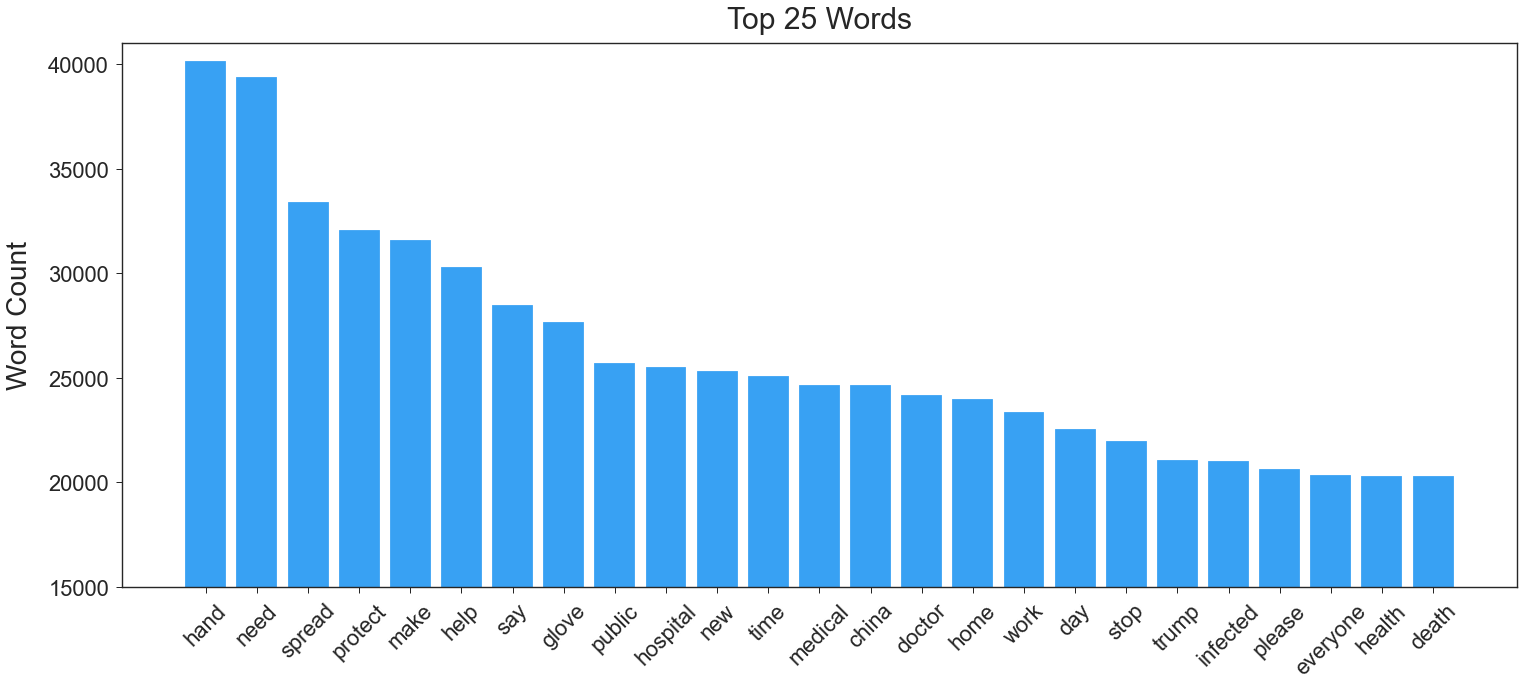

In [40]:
plt.figure(figsize=(25,10))
plt.title('Top 25 Words', fontsize=30, pad=15)
plt.ylabel('Word Count', fontsize=28, labelpad=15)
plt.xticks(rotation=45, fontsize=22)
plt.yticks(fontsize=22)
plt.ylim(bottom=15000, top=41000)

# plot bar chart with twitter blue ;)
plt.bar(top25_words.index, top25_words.word_count, color='#38A1F3');

## LDA
#### Topic modeling!
#### PLEASE NOTE: These are not our original topics. Unfortunately we lost those (except for a screenshot, which resides in our Images folder); we used those original topics for our presentation

In [41]:
# one of the required inputs is a term-document matrix
tdm = data_vec.transpose()
tdm.head()

# put the term-document matrix into a new gensim format, from df --> sparse matrix --> gensim corpus
# TAKES AWHILE
sparse_counts = scipy.sparse.csr_matrix(tdm)
corpus = matutils.Sparse2Corpus(sparse_counts)

# gensim also requires dictionary of the all terms and their respective location in the term-document matrix
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

###### Pickle the gensim corpus and vocab locations

In [42]:
# uncomment to save
# with gzip.open('Datasets/gensim_corpus.pkl', 'wb') as c:
#     pickle.dump(corpus, c, protocol=pickle.HIGHEST_PROTOCOL)
    
# with gzip.open('Datasets/gensim_id2word.pkl', 'wb') as i:
#     pickle.dump(id2word, i, protocol=pickle.HIGHEST_PROTOCOL)

In [48]:
# uncomment to load
# with gzip.open('gensim_corpus.pkl', 'rb') as c:
#     corpus = pickle.load(c)
    
# with gzip.open('gensim_id2word.pkl', 'rb') as i:
#     id2word = pickle.load(i)

###### Use corpus and dictionary of term locations, and set number of topics and passes to create an LDA model
###### NOTE: keeping passes low due to the size of our dataset

In [49]:
# create the topics
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, passes=10)

# view the topics
lda.print_topics()

[(0,
  '0.058*"facewithmedicalmask" + 0.028*"week" + 0.023*"today" + 0.020*"#staysafe" + 0.019*"order" + 0.018*"#lockdown" + 0.016*"employee" + 0.015*"crisis" + 0.013*"local" + 0.013*"box"'),
 (1,
  '0.064*"new" + 0.057*"case" + 0.049*"death" + 0.038*"protest" + 0.020*"lockdown" + 0.017*"number" + 0.017*"fear" + 0.015*"news" + 0.015*"droplet" + 0.013*"country"'),
 (2,
  '0.052*"home" + 0.044*"stay" + 0.042*"please" + 0.040*"safe" + 0.040*"keep" + 0.039*"hand" + 0.023*"take" + 0.015*"wash" + 0.012*"#socialdistancing" + 0.012*"sanitizer"'),
 (3,
  '0.045*"trump" + 0.014*"business" + 0.014*"police" + 0.013*"fauci" + 0.013*"life" + 0.011*"say" + 0.011*"american" + 0.011*"rule" + 0.010*"positive" + 0.010*"second"'),
 (4,
  '0.052*"social" + 0.045*"distancing" + 0.034*"spread" + 0.030*"protect" + 0.021*"others" + 0.019*"stop" + 0.017*"infected" + 0.017*"distance" + 0.017*"prevent" + 0.016*"help"'),
 (5,
  '0.025*"state" + 0.018*"health" + 0.016*"worker" + 0.014*"patient" + 0.012*"medical" + 

###### Pickle it!

In [50]:
with open('models/lda_model_10_topics_10_passes.pkl', 'wb') as handle:
    pickle.dump(lda, handle, protocol=pickle.HIGHEST_PROTOCOL)

###### Assign each tweet to the topic to which it most closely fits

In [51]:
corpus_transformed = lda[corpus]

In [52]:
len(corpus_transformed)

575949

In [53]:
corpus_transformed[0]

[(0, 0.020016158),
 (1, 0.1597161),
 (2, 0.020016158),
 (3, 0.020018646),
 (4, 0.2196404),
 (5, 0.21993728),
 (6, 0.020016158),
 (7, 0.2806068),
 (8, 0.020016158),
 (9, 0.020016158)]

In [54]:
# turn our LDA corpus into a column
df['lda_scores'] = corpus_transformed
df['lda_scores'].head()

0    [(0, 0.020016162), (1, 0.16171636), (2, 0.020016162), (3, 0.0200178), (4, 0.21964042), (5, 0.21993735), (6, 0.020016162), (7, 0.27860725), (8, 0.0...
1                                                                                       [(5, 0.0974396), (6, 0.1636191), (7, 0.54697824), (9, 0.14908998)]
2                                                                  [(0, 0.061181605), (1, 0.061553374), (2, 0.28873074), (4, 0.21947171), (7, 0.34124833)]
3    [(0, 0.020004174), (1, 0.020013815), (2, 0.020004174), (3, 0.020006256), (4, 0.020004174), (5, 0.020004174), (6, 0.020005008), (7, 0.8199499), (8,...
4    [(0, 0.014292977), (1, 0.23047026), (2, 0.014292977), (3, 0.014294527), (4, 0.15703824), (5, 0.014292977), (6, 0.15701887), (7, 0.014293624), (8, ...
Name: lda_scores, dtype: object

In [55]:
# obtain the topic that a resembles the tweet most
df['lda'] = df['lda_scores'].apply(lambda x: lda_getter(x))
df['lda'].head()

0    7
1    7
2    7
3    7
4    9
Name: lda, dtype: int64

##### Let's see if there's any discernable relationship between topics and time

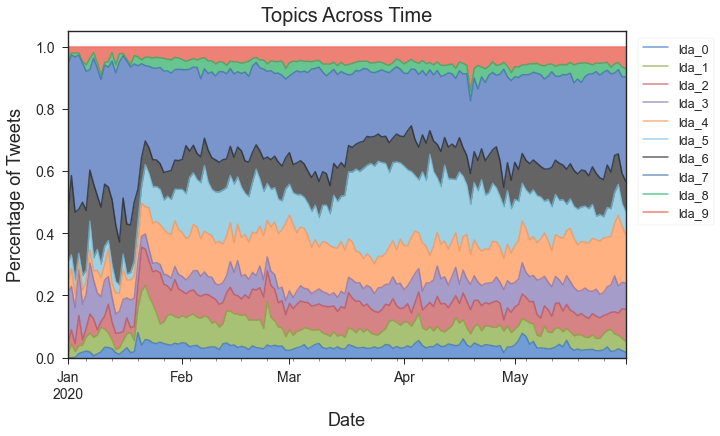

In [56]:
# sort by percentage of trees in good health
days = df.groupby('date').lda.value_counts(normalize=True).unstack()

# plot a stacked bar graph
p1 = days.plot.area(stacked = True, figsize=(10,6),
#                    title = 'Tree Health Across Boroughs', 
                   alpha = .70, fontsize=14)

p1.set_title('Topics Across Time', fontsize=20, pad=10)
p1.set_xlabel('Date', fontsize=18, labelpad=10)
p1.set_ylabel('Percentage of Tweets', fontsize=18, labelpad=10)
p1.legend([f'lda_{i}' for i in range(10)], facecolor='white',
          framealpha=1, bbox_to_anchor=(1.01, 1.0), loc='upper left')
plt.show()

##### Cool looking graph but not super helpful
##### Look at the relationship between sentiment and topics

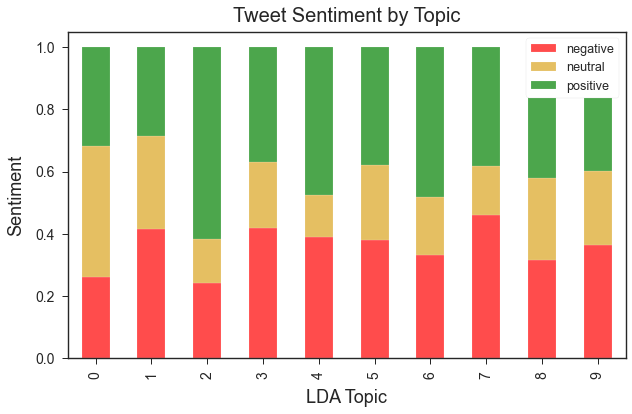

In [57]:
# sort by percentage of trees in good health
days = df.groupby('lda').sentiment.value_counts(normalize=True).unstack()

# plot a stacked bar graph
p1 = days.plot(kind='bar', stacked = True, figsize=(10,6),
#                    title = 'Tree Health Across Boroughs', 
                   color = ['red', 'goldenrod', 'green'], alpha = .70, fontsize=14)

p1.set_title('Tweet Sentiment by Topic', fontsize=20, pad=10)
p1.set_xlabel('LDA Topic', fontsize=18, labelpad=10)
p1.set_ylabel('Sentiment', fontsize=18, labelpad=10)
p1.legend(['negative', 'neutral', 'positive'], facecolor='white', framealpha=1)
plt.show()

##### Some definite affect on sentiment based on tweet topic

In [58]:
lda.print_topics()

[(0,
  '0.058*"facewithmedicalmask" + 0.028*"week" + 0.023*"today" + 0.020*"#staysafe" + 0.019*"order" + 0.018*"#lockdown" + 0.016*"employee" + 0.015*"crisis" + 0.013*"local" + 0.013*"box"'),
 (1,
  '0.064*"new" + 0.057*"case" + 0.049*"death" + 0.038*"protest" + 0.020*"lockdown" + 0.017*"number" + 0.017*"fear" + 0.015*"news" + 0.015*"droplet" + 0.013*"country"'),
 (2,
  '0.052*"home" + 0.044*"stay" + 0.042*"please" + 0.040*"safe" + 0.040*"keep" + 0.039*"hand" + 0.023*"take" + 0.015*"wash" + 0.012*"#socialdistancing" + 0.012*"sanitizer"'),
 (3,
  '0.045*"trump" + 0.014*"business" + 0.014*"police" + 0.013*"fauci" + 0.013*"life" + 0.011*"say" + 0.011*"american" + 0.011*"rule" + 0.010*"positive" + 0.010*"second"'),
 (4,
  '0.052*"social" + 0.045*"distancing" + 0.034*"spread" + 0.030*"protect" + 0.021*"others" + 0.019*"stop" + 0.017*"infected" + 0.017*"distance" + 0.017*"prevent" + 0.016*"help"'),
 (5,
  '0.025*"state" + 0.018*"health" + 0.016*"worker" + 0.014*"patient" + 0.012*"medical" + 

## Subjectivity
##### Use TextBlob to calculate the subjectivity of tweets

In [59]:
df['subjectivity_score'] = df['tweet'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df.subjectivity_score.head()

0    0.600000
1    0.560000
2    0.462963
3    0.000000
4    0.500000
Name: subjectivity_score, dtype: float64

In [60]:
df.subjectivity_score.describe()

count    575949.000000
mean          0.370732
std           0.290762
min           0.000000
25%           0.050000
50%           0.397576
75%           0.565000
max           1.000000
Name: subjectivity_score, dtype: float64

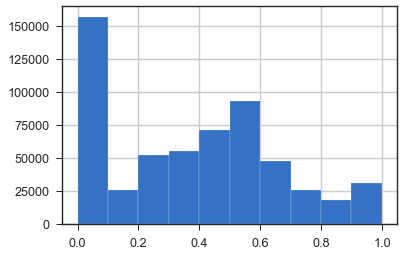

In [61]:
df.subjectivity_score.hist()

###### Look at the relationship between subjectivity and sentiment

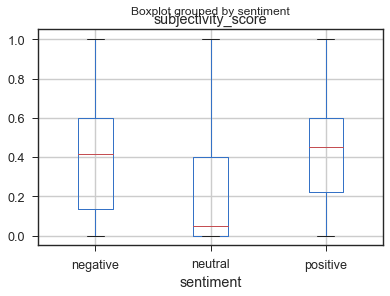

In [62]:
df.boxplot('subjectivity_score', 'sentiment')

###### As expected, neutral tweets tend to be more objective, whereas positive and negative tweets are more subjective.

###### How about between subjectivity and LDA topics?

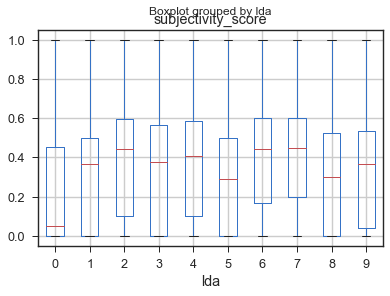

In [63]:
df.boxplot('subjectivity_score', 'lda')

###### Some difference here but nothing too telling, given the generalness of LDA topics.
###### Make sure our DataFrame has all the columns.

In [64]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'tweet', 'hashtags',
       'user_id', 'username', 'name', 'link', 'retweet', 'nlikes', 'nreplies',
       'nretweets', 'quote_url', 'retweet_id', 'reply_to', 'sentiment_score',
       'sentiment', 'month', 'clean_tweet', 'lda_scores', 'lda',
       'subjectivity_score'],
      dtype='object')

#### Save for good measure

In [65]:
# uncomment to save
# df.to_csv('Datasets/5k_jan_thru_may_tweets_plus_features.csv')